In [1]:
import sys,os,copy, pickle, glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
from builder.manipulator import Manipulator
from tester.predictor import Predictor
from tester.combiner import Combiner
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
from smodels.tools.physicsUnits import GeV,fb
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from names import particleLabels
from sparticleNames import SParticleNames
import pandas as pd
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
# sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("deep"))
from smodels.tools import smodelsLogging
smodelsLogging.setLogLevel('error')

In [2]:
def fromDict(inputDict):
    
    p = ProtoModel(walkerid=0)
    for key,v in inputDict.items():
        setattr(p,key,copy.deepcopy(v))
        
    return p

def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict

In [35]:
modelList = []
for modelFile in glob.glob('../data_previous/real*.dict'):
    with open(modelFile,'r') as f:
        pList = eval(f.read())
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    modelList.append(p)
    
modelListNew = []
for modelFile in glob.glob('../data/real*.dict'):
    with open(modelFile,'r') as f:
        pList = eval(f.read())
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    modelListNew.append(p)
protomodel = copy.deepcopy(modelList[0])

In [4]:
print(p,p.masses)

ProtoModel (XZ1,Xd,Xt,Xmu): K = 7.13, Z = 3.45 {1000022: 16.692, 1000001: 651.363, 1000006: 1126.127, 1000013: 276.424}


### Compute prediction without capping and drmax = 0.4

In [5]:
#Compute predictions:
runtime._cap_likelihoods = False
runtime._drmax = 0.4
dbpath = '../official124_smodels200.pcl'
pred = Predictor(walkerid=0,dbpath=dbpath)
res = pred.predict(p)

[combine:0] selected predictions down via SRs from 232 to 18.
[combine:0] sorting out subsets, reduced 3053 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


[combine:0] selected predictions down via SRs from 232 to 18.
[combine:0] sorting out subsets, reduced 3053 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


In [6]:
print(p)

ProtoModel (XZ1,Xd,Xt,Xmu): K = 7.13, Z = 3.45


In [7]:
muvals = np.linspace(-10,10,500)
llhDict = getLikelihoods(p,muvals)

### Compute prediction with capping

In [8]:
#Compute predictions:
pNew = copy.deepcopy(protomodel)
runtime._cap_likelihoods = True
runtime._drmax = 0.338
pred = Predictor(walkerid=0,dbpath=dbpath)
resNew = pred.predict(pNew)

[combine:0] selected predictions down via SRs from 262 to 19.
[combine:0] sorting out subsets, reduced 2788 -> 288 combinations.


combination #288/288 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:22


[combine:0] selected predictions down via SRs from 262 to 19.
[combine:0] sorting out subsets, reduced 2788 -> 288 combinations.


combination #288/288 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:25


In [9]:
llhDictNew = getLikelihoods(pNew,muvals)

### Plot likelihoods

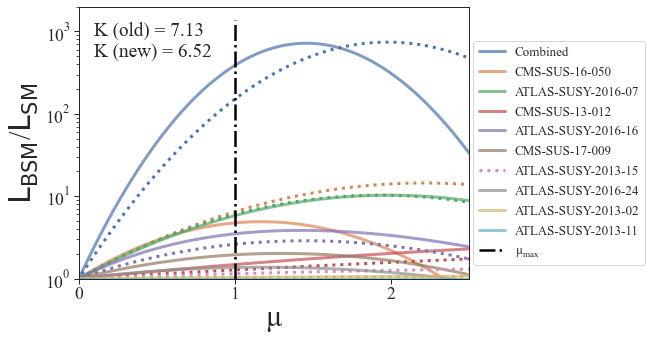

In [16]:
sortedKeys = []
for key in list(set(list(llhDictNew.keys())+list(llhDict.keys()))):
    if key == 'SM values' or key == 'Critic':
        continue
    else:
        if key in llhDictNew:
            sortedKeys.append((llhDictNew[key].max()/llhDictNew['SM values'][key],key))
        else:
            sortedKeys.append((llhDict[key].max()/llhDict['SM values'][key],key))
            
sortedKeys = sorted(sortedKeys,reverse=True)
sortedKeys = [pt[1] for pt in sortedKeys]

#Set colors:
colorPalette = 'deep' #Set color palette for particles, if None use default
colorList = sns.color_palette(palette=colorPalette,n_colors=len(sortedKeys))

fig = plt.figure(figsize=(7,5))
for i,key in enumerate(sortedKeys):
    color = colorList[i]
    if key in llhDict:
        val = llhDict[key]
        plt.plot(muvals,val/llhDict['SM values'][key],label=key,
                  linestyle='-',linewidth=3,alpha=0.7,color=color)
    if key in llhDictNew:
        val = llhDictNew[key]
        if not key in llhDict:
            label = key
        else:
            label = None
        plt.plot(muvals,val/llhDictNew['SM values'][key],linewidth=3,
                 linestyle='dotted',color=color,label=label)
        

plt.axvline(x=p.mumax,ymax=0.95,c='black',linestyle='-.',label=r'$\mathdefault{\mu_{max}}$',
               linewidth=2.5)
plt.xticks(np.linspace(0,5,6))
plt.xlabel(r'$\mathdefault{\mu}$',fontsize=30)
plt.ylabel(r'$\mathdefault{\mathrm{L}_{\mathrm{BSM}}/\mathrm{L}_{\mathrm{SM}}}$',fontsize=30)
plt.legend(loc=(1.01,0.05),framealpha=1,fontsize=13,labelspacing=0.6)
plt.xlim(0,2.5)
plt.ylim(1,2e3)
plt.yscale('log')
plt.text(0.1,5e2,'K (old) = %1.2f\nK (new) = %1.2f' %(p.K,pNew.K))
plt.show()

In [17]:
for tp in p.bestCombo:
    if tp.expResult.globalInfo.id != 'CMS-SUS-16-050':
        continue
    print(tp.txnames)
    print(tp.elements,tp.xsection)
    print('UL=',tp.upperLimit,tp.expectedUL,tp.likelihood)

[T2tt]
[[[[t-]],[[t+]]]] 1.30E+01 [TeV]:2.01E-03 [pb] (None, None)
UL= 4.52E+00 [fb] 2.57E+00 [fb] 0.008512398782371342


In [18]:
for tp in pNew.bestCombo:
    if tp.expResult.globalInfo.id != 'CMS-SUS-16-050':
        continue
    print(tp.txnames)
    print(tp.elements,tp.xsection)
    print('UL=',tp.upperLimit,tp.expectedUL,tp.likelihood)

[T2tt]
[[[[t-]],[[t+]]]] 1.30E+01 [TeV]:3.06E-02 [pb] (None, None)
UL= 1.32E+02 [fb] 5.74E+01 [fb] 0.00017225501492783928


### Get UL_obs, UL_exp and relative difference for CMS-SUS-16-050:T2tt

In [19]:
for tp in pNew.bestCombo:
    if tp.expResult.globalInfo.id == 'CMS-SUS-16-050':
        tx = [t for t in tp.expResult.datasets[0].txnameList if str(t) == 'T2tt'][0]
print(tx)

T2tt


In [20]:
mLSP = np.linspace(0.,1000,100)
mSt = np.linspace(200.,2000,200)
points = []
for m0 in mSt:
    for m1 in mLSP:
        if m0-m1 < 175.0:
            continue
        ULobs = tx.getULFor([[m0*GeV,m1*GeV]]*2,expected=False)
        ULexp = tx.getULFor([[m0*GeV,m1*GeV]]*2,expected=True)
        if ULobs is None or ULexp is None:
            continue
        if ULobs == ULexp:
            relDiff = 0.0
        else:
            relDiff = abs(ULobs-ULexp)/(ULobs+ULexp)
            relDiff = relDiff.asNumber()
        points.append([m0,m1,ULobs.asNumber(fb),ULexp.asNumber(fb),relDiff])

In [21]:
points = np.array(points)

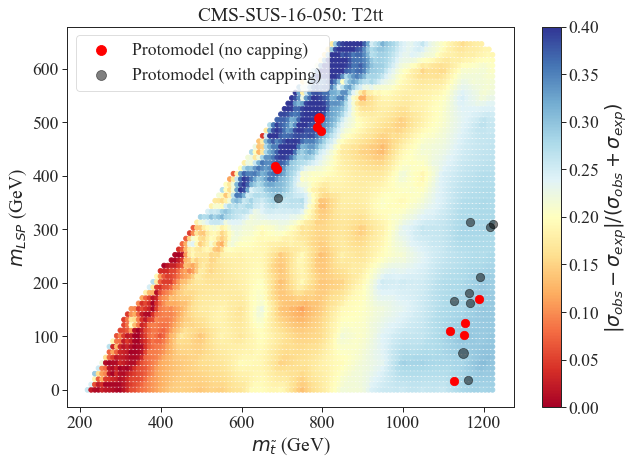

In [39]:
fig = plt.figure(figsize=(10,7))
plt.scatter(points[:,0],points[:,1],c=points[:,4],cmap=plt.cm.get_cmap('RdYlBu'),
            vmin=0.,vmax=0.4)
plt.xlabel(r'$m_{\tilde t}$ (GeV)')
plt.ylabel(r'$m_{LSP}$ (GeV)')
plt.colorbar(label=r'$|\sigma_{obs}-\sigma_{exp}|/(\sigma_{obs}+\sigma_{exp})$')
#Plot protomodel masses:

plt.scatter(modelList[0].masses[1000006],modelList[0].masses[1000022],
            s=100,c='red',marker='o',label='Protomodel (no capping)')

plt.scatter(modelListNew[0].masses[1000006],modelListNew[0].masses[1000022],
            s=100,c='black',marker='o',label='Protomodel (with capping)',alpha=0.5)

for pmodel in modelList[1:]:
    plt.scatter(pmodel.masses[1000006],pmodel.masses[1000022],s=70,c='red',marker='o')
for pmodel in modelListNew[1:]:
    plt.scatter(pmodel.masses[1000006],pmodel.masses[1000022],s=70,c='black',marker='o',alpha=0.5)

    
plt.legend()
plt.title('CMS-SUS-16-050: T2tt')
plt.show()

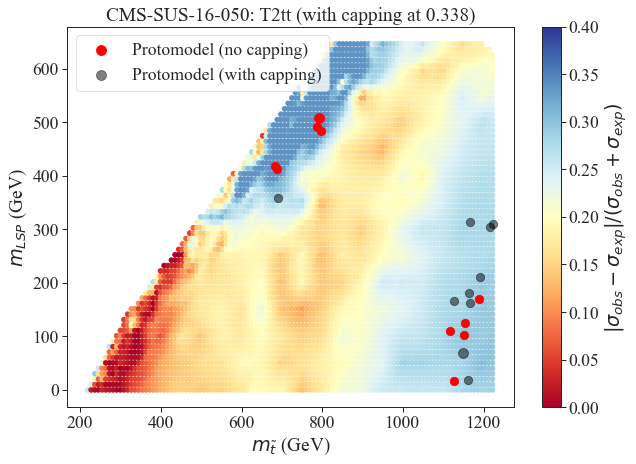

In [42]:
fig = plt.figure(figsize=(10,7))

plt.scatter(points[:,0],points[:,1],c=np.minimum(0.338,points[:,4]),cmap=plt.cm.get_cmap('RdYlBu'),
            vmin=0.,vmax=0.4)
plt.xlabel(r'$m_{\tilde t}$ (GeV)')
plt.ylabel(r'$m_{LSP}$ (GeV)')
plt.colorbar(label=r'$|\sigma_{obs}-\sigma_{exp}|/(\sigma_{obs}+\sigma_{exp})$')
#Plot protomodel masses:

plt.scatter(modelList[0].masses[1000006],modelList[0].masses[1000022],
            s=100,c='red',marker='o',label='Protomodel (no capping)')

plt.scatter(modelListNew[0].masses[1000006],modelListNew[0].masses[1000022],
            s=100,c='black',marker='o',label='Protomodel (with capping)',alpha=0.5)

for pmodel in modelList[1:]:
    plt.scatter(pmodel.masses[1000006],pmodel.masses[1000022],s=70,c='red',marker='o')
for pmodel in modelListNew[1:]:
    plt.scatter(pmodel.masses[1000006],pmodel.masses[1000022],s=70,c='black',marker='o',alpha=0.5)

    
plt.legend()
plt.title('CMS-SUS-16-050: T2tt (with capping at 0.338)')
plt.show()